# Demonstration of Self-Organizing Maps (SOMs)
#### by Elizabeth Barnes


In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter

from minisom import MiniSom   

import matplotlib as mpl
import seaborn as sns


# set figure defaults
fig_text_default = 12.
fig_title_default = fig_text_default*1.1
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 150

#plt.rc('lines', linewidth=linewidth_default)    
#plt.rc('text', usetex=False)
#mpl.rcParams['xtick.labelsize'] = fig_text_default

sns.set()
sns.set_style("whitegrid")



### Get your data together

In [16]:
filename = 'data/christman_2016.csv'
data_input = np.genfromtxt(filename, delimiter = ',')

# grab the variables I want, but do not include day of year or time of day since
# SOM takes the average of the values and these are cyclic
grab_indices = [2,3,5,9,10,11] 

data = data_input[:,grab_indices]

names_input = ['date','time','temp (F)', 'RH (%)', 'DewPt (F)','Wind (mph)', 'Dir (deg.)', 'Gust (mph)', 'Gust Dir (deg.)','Pres (mb)', 'Solar (W/m^2)','Precip (in)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
names[names.index('Precip (in)')] = 'Precip (mm)'

In [17]:
print(np.shape(data))

(8784, 6)


### Run the SOM code!
This is where the SOM magic happens. Not a lot of actual lines of code on my part, but the miniSom module has a lot of code itself. We will discuss the details more in class, however, note that this is where I decide how many SOMs I want. Namely, I choose a 20x20 grid. This is totally up to me and *will* change my answer.

In [18]:
dim = (20,20)

In [19]:
som = MiniSom(dim[0],dim[1],np.shape(data)[1], sigma=1.5, learning_rate = .1, neighborhood_function='gaussian')

In [20]:
som.pca_weights_init(data)

In [21]:
som.train_random(data, 500, verbose=True)
#som.train_batch(data,1000, verbose=True)

 [ 500 / 500 ] 100% 0.00889 it/s

In [22]:
codebook = som.get_weights()
print(np.shape(codebook))

(20, 20, 6)


In [23]:
dataNeurons = som.quantization(data)
np.shape(dataNeurons)

(8784, 6)

Let's look at one particular day.

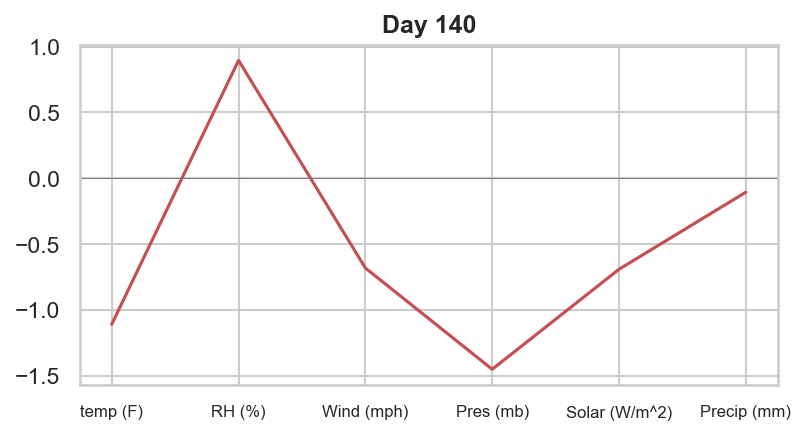

(17, 1)


In [24]:
day = 140
plt.figure(figsize=(6,3))
plt.plot((data[day,:]-np.mean(data,axis=0))/np.std(data,axis=0), color='r')
#plt.plot(np.mean(data,axis=0),'--',color='k')
plt.xticks(np.arange(len(names)),names, fontsize = 8)
plt.title('Day ' + str(day))
plt.axhline(color='gray',linewidth=.5)
plt.show()
neuron_day = som.winner(data[day,:])
print(neuron_day)

### Plot the SOM "patterns"
In this case, my SOM patterns aren't actually patterns, but values for each of my six variables. There are many ways I could plot this, but I have chosen to divide each of the variables into a grid, where each gridbox is associated with a different SOM. That is, the true "SOM #1" is actually a combination of all six variables taking on their values in the upper-left hand corner of the plot.

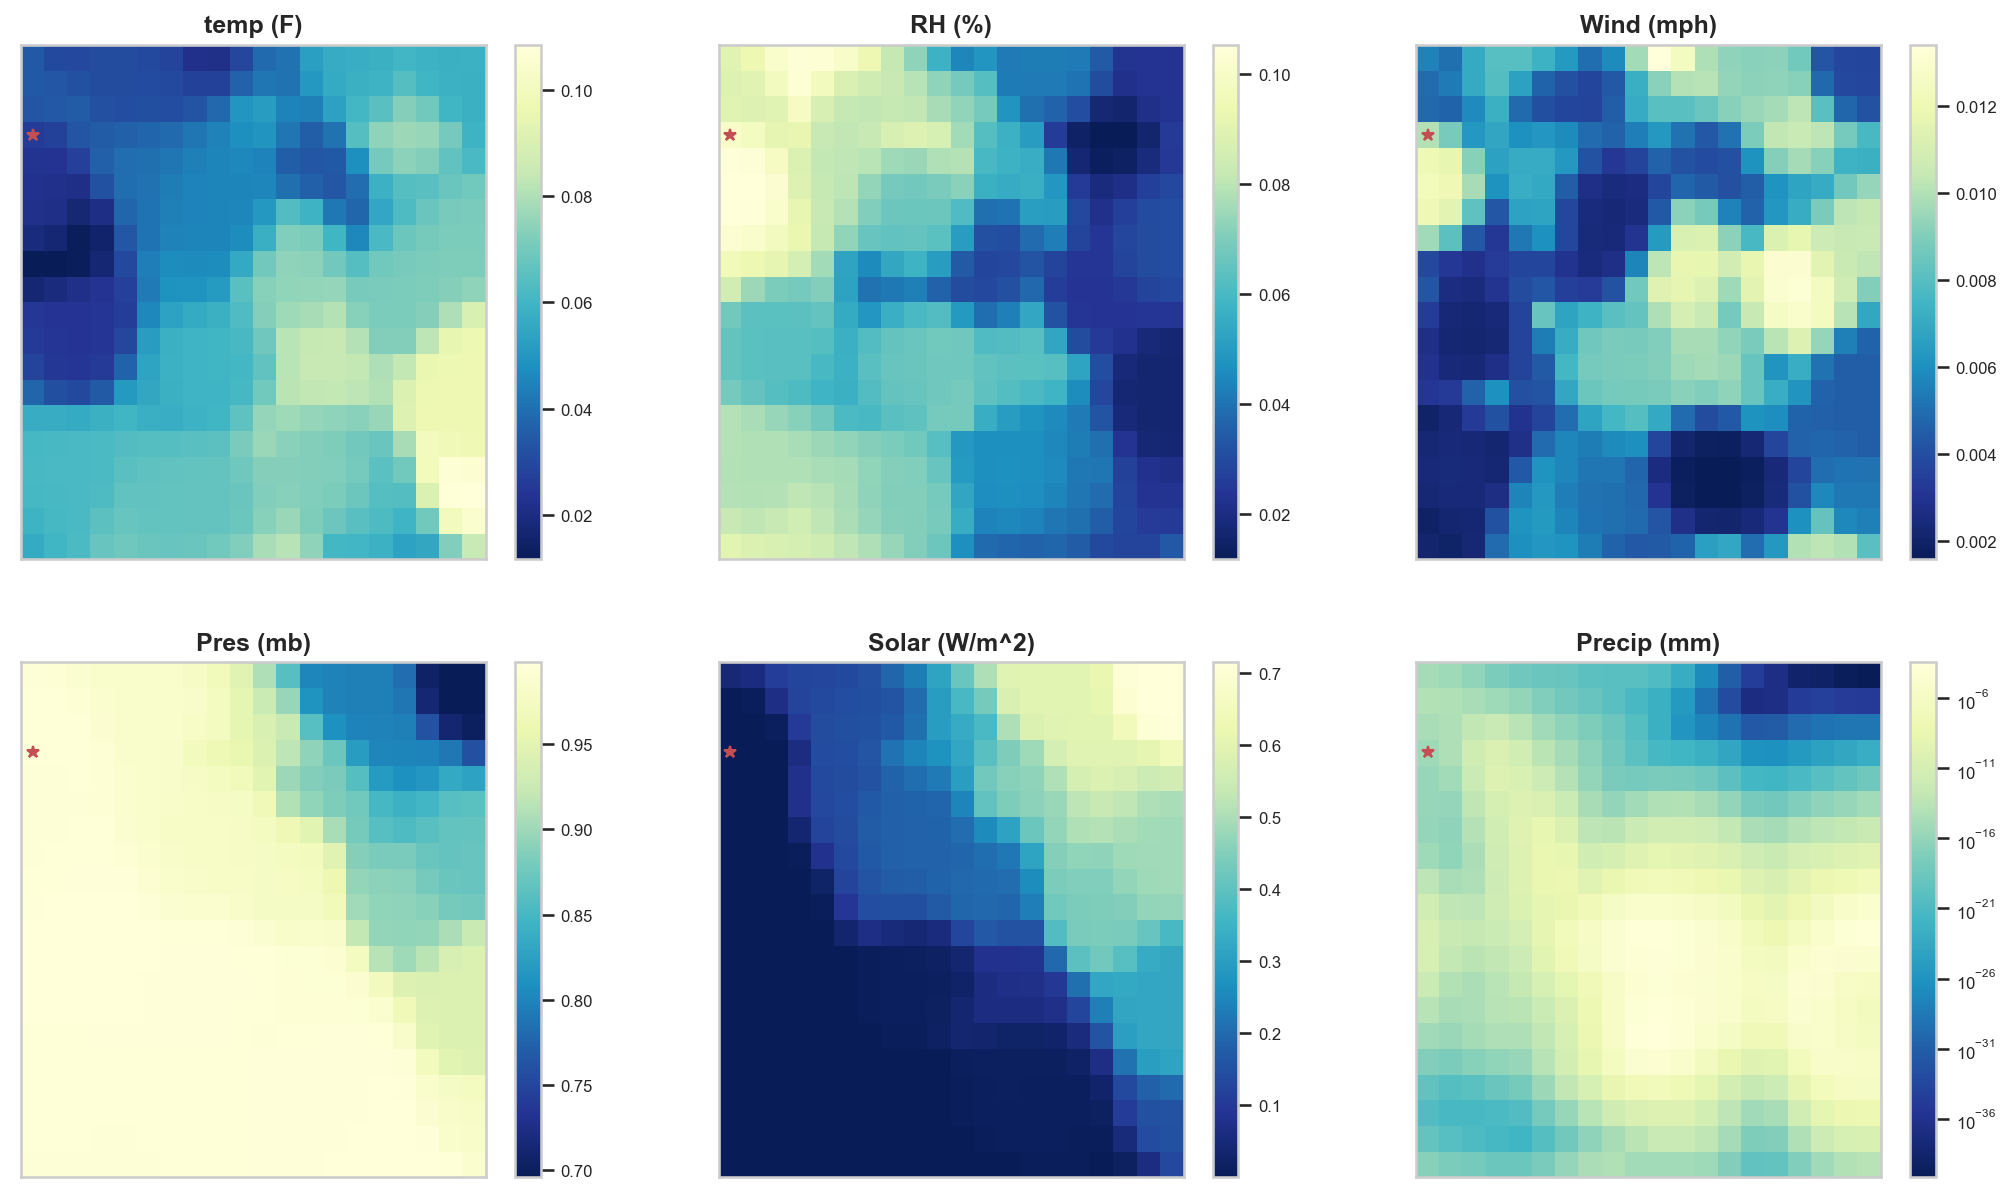

In [25]:
#neuron_day = (7,2)
# choose my colorbar
my_cmap = plt.cm.get_cmap('YlGnBu_r')

# make the plot
plt.figure(figsize=(17,10))
for ind in range(0,np.size(codebook,axis=2)):
    weights = codebook[:,:,ind]
    
    ax = plt.subplot(2, 3, ind+1)
    
    plt.axis([0, dim[0], 0, dim[1]])
    if(names[ind] in 'Precip (mm)'):
        pl = plt.pcolormesh(weights, cmap = my_cmap, norm=colors.LogNorm(vmin=weights.min(), vmax=weights.max()))
        #pl = plt.pcolor(weights, cmap = my_cmap)
    else:
        pl = plt.pcolormesh(weights, cmap = my_cmap)

    plt.plot(neuron_day[1]-.5,neuron_day[0]-.5,'*r')    
    plt.yticks([])
    plt.xticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    plt.title(names[ind])

   
plt.show()

### Plot the "hits" map
The "Hits Map" is a map of how many times a particular sample falls into a particular SOM. In our example here, what is the number of days that look like each SOM? We see from the hits map below where the most frequent SOMs/states of the atmosphere lie. So, we can go and look at the figure above and see what values the different variables take-on during this time. Looks like "cold/moist/low wind/mix of pressures/cloudy/precipitating a little" (at least that is what it looked like when I ran this!).

In [26]:
frequencies = np.zeros((dim[0],dim[1]))
x = np.zeros((dim[0],dim[1]))
y = np.zeros((dim[0],dim[1]))
for position, values in som.win_map(data).items():
    frequencies[position[0], position[1]] = len(values)
    x[position[0], position[1]] = position[0]
    y[position[0], position[1]] = position[1]

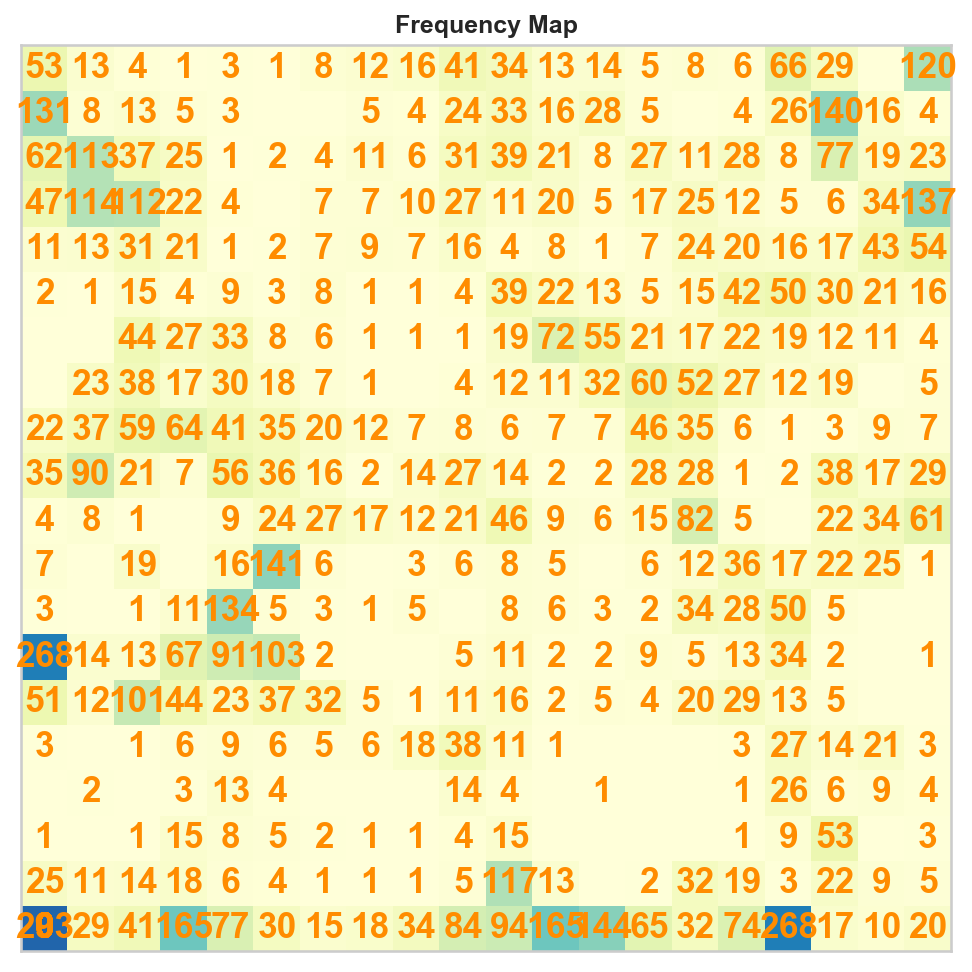

In [29]:
# this function just makes it faster to write the numbers in each of the grid boxes
def set_labels(x,y, ax, labels, fontsize):
    for i, txt in enumerate(labels.flatten()):
        plt.annotate(int(txt), (y.flatten()[i] + 0.5, x.flatten()[i] + 0.5), va="center", ha="center", 
            size=fontsize, color = 'darkorange', fontweight = 'bold')

# choosing my colorbar
my_cmap = plt.cm.get_cmap('YlGnBu')
        
# plot the results
plt.figure(figsize=(8,8))
ax = plt.gca()
set_labels(x,y, ax, np.round(frequencies), fontsize=17)

plt.title('Frequency Map')
pl = plt.pcolormesh(frequencies, cmap=my_cmap)
plt.axis([0, dim[0], 0, dim[1]])
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.clim(0,400)
plt.show()

Text(0.5, 1.0, 'Frequencies')

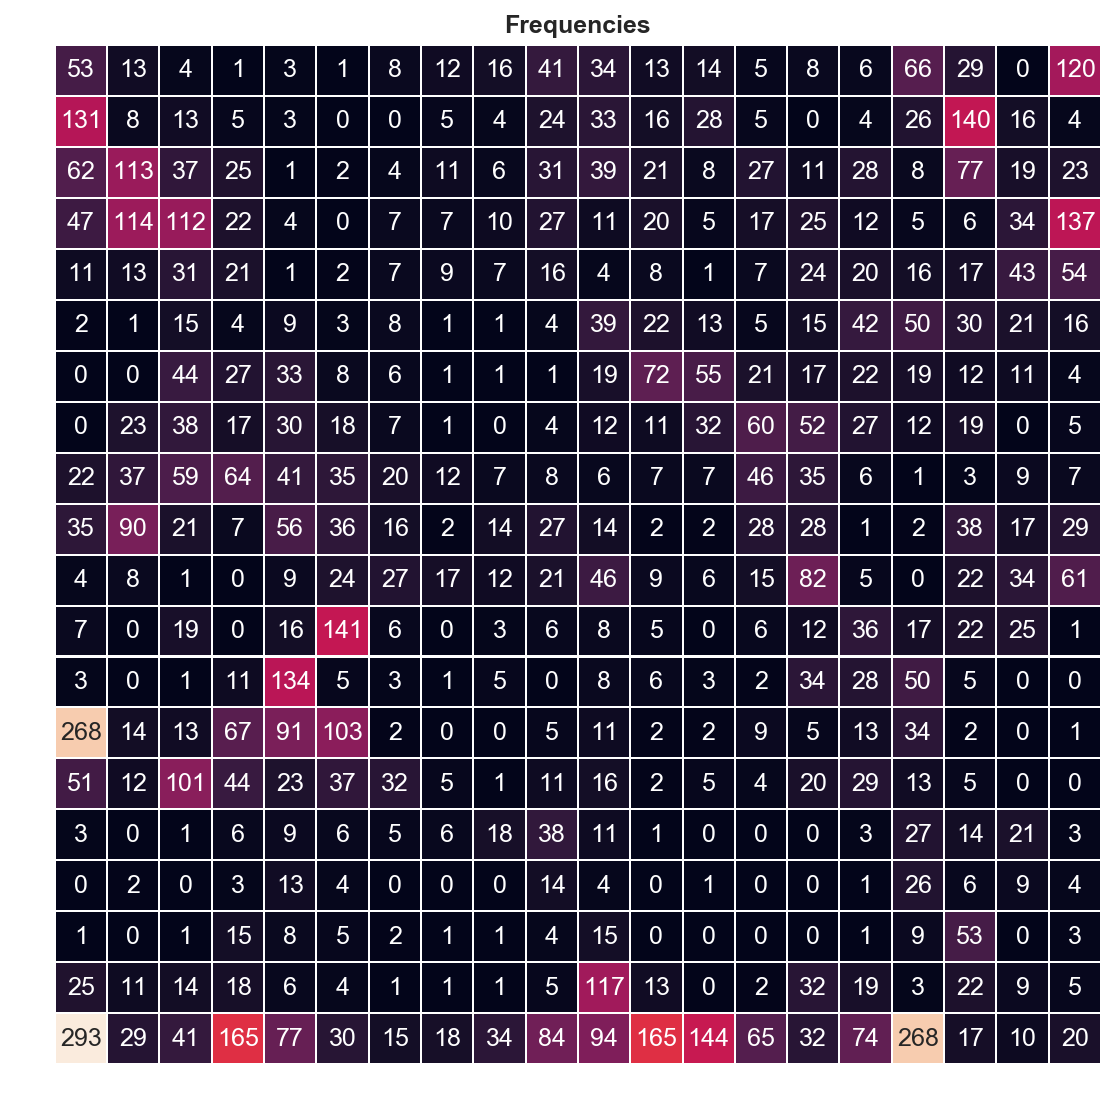

In [28]:
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(np.flipud(frequencies), annot=True, fmt='g', linewidths=.5, ax=ax, cbar=False)
ax.axis('off')
plt.title('Frequencies')